# Track classifier demo

Simple demo to show implementation of a convolutional neural network to classify CR-like tracks. Based on [this](https://github.com/tflearn/tflearn/blob/master/examples/images/convnet_cifar10.py) tflearn example.  

Tested with:
* python 3.6.4
* tflearn 0.3.2
* tensorflow 1.6.0

In [1]:
%matplotlib inline
import sys
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2" # to stop warnings with tensorflow
sys.path.append('../')
from generate_sample_frames import *
import tflearn
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation
from matplotlib import pyplot as plt
import numpy as np
import pickle

/Users/fran/projects/kth/kex_ML/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


* Create samples to train the network by defining a TrackModel() and the required number of frames
* Equal numbers of background and track frames are generated and labelled and a random sample of these is displayed

generated 360 frames of background
generated 360 background labels
displaying a random sample of 36 frames: 


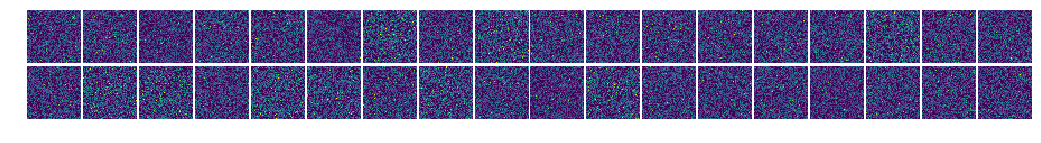

generated 360 frames of tracks
genarated 360 track labels
displaying a random sample of 36 frames: 


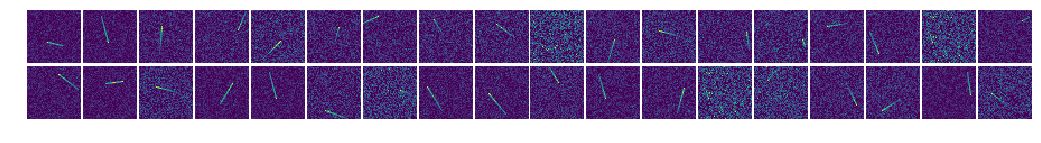

saved generated frames to file in samples/


In [2]:
# set up the TrackModel
track_model = TrackModel()
track_model.mu_c = 10
n_frame = 360

# generate sample background and tracks
with SampleGenerator(track_model) as generator:
    generator.background(n_frame)
    generator.tracks(n_frame)
    generator.save()

* Read in the data and label files generated in the previous step and stored in the ```samples/``` directory 

In [3]:
outfilename = 'samples/sample_generator_bg.dat'
with open(outfilename, 'rb') as f:
    data_bg = pickle.load(f)

outfilename = 'samples/sample_generator_track.dat'
with open(outfilename, 'rb') as f:
    data_track = pickle.load(f)
    
outfilename = 'samples/sample_generator_bg_labels.dat'
with open(outfilename, 'rb') as f:
    labels_bg = pickle.load(f)

outfilename = 'samples/sample_generator_track_labels.dat'
with open(outfilename, 'rb') as f:
    labels_track = pickle.load(f)

* peform basic preprocessing on the data, creating a shuffled list of data and corresponding labels with which to train the network
* define a fraction of the data to be used for validation

In [4]:
data = np.concatenate([data_bg, data_track])
data = np.reshape(data, (2*n_frame, 48, 48, 1))

labels = np.concatenate([labels_bg, labels_track])

data, labels = shuffle(data, labels)

validation_ratio = 1/5
index = int(1 - validation_ratio * np.shape(data)[0] / 2) - 1

data_test = data[index:]
labels_test = labels[index:]

data = data[0:index]
labels = labels[0:index]

# Make sure the data is normalised
img_prep = ImagePreprocessing()
img_prep.add_featurewise_zero_center()
img_prep.add_featurewise_stdnorm()

* Build the network
    * define input format
    * define layers

In [5]:
# INPUT FORMAT
# input data is a 48 x 48 array with 1 'colour' channel
network = input_data(shape=[None, 48, 48, 1])

# LAYERS
# step 1: convolution
network = conv_2d(network, 48, 3, activation='relu')

# step 2: max pooling
network = max_pool_2d(network, 2)

# step 3: convolution again
network = conv_2d(network, 64, 3, activation='relu')

# step 4: convolution yet again
network = conv_2d(network, 64, 3, activation='relu')

# step 5: max pooling again
network = max_pool_2d(network, 2)

# step 6: fully-connected 512 node neural network
network = fully_connected(network, 512, activation='relu')

# step 7: dropout - throw away some data randomly during training to prevent over-fitting
network = dropout(network, 0.5)

# step 8: fully-connected neural network with two outputs
network = fully_connected(network, 2, activation='softmax')

# tell tflearn how to train the network
network = regression(network, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.001)

# wrap the network in a model object and add tensorboard output
model = tflearn.DNN(network, tensorboard_verbose=3, checkpoint_path='logs/track-classifier.tfl.ckpt')

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


* Train the network

In [6]:
# make 50 passes through the data with a batch size of 16 and a validation set as defined above
model.fit(data, labels, n_epoch=50, shuffle=True, validation_set=(data_test, labels_test),
          show_metric=True, batch_size=16,
          snapshot_epoch=True,
          run_id='track-classifier')

# save model when training is complete to a file
model.save("track-classifier.tfl")
print("Network trained and saved as track-classifier.tfl!")

Training Step: 2049  | total loss: 0.08994 | time: 11.057s
| Adam | epoch: 050 | loss: 0.08994 - acc: 0.9917 -- iter: 640/648
Training Step: 2050  | total loss: 0.08124 | time: 12.325s
| Adam | epoch: 050 | loss: 0.08124 - acc: 0.9926 | val_loss: 0.35782 - val_acc: 0.9028 -- iter: 648/648
--
INFO:tensorflow:/Users/fran/projects/kth/kex_ML/examples/track-classifier.tfl.ckpt-2050 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:/Users/fran/projects/kth/kex_ML/examples/track-classifier.tfl is not in all_model_checkpoint_paths. Manually adding it.
Network trained and saved as track-classifier.tfl!


* To see output tensorboard visualisation run ```tensorboard --logdir='/tmp/tflearn_logs'```